# OpenAI-Metadata-Tagger Prompt Tuning

This notebook documents the process of fine-tuning prompts that are used with GPT-3-based [0] zero-shot learning. Speficically, the OpenAI-Metadata-Tagger, provided in the Langchain framework [1], is used for this task. The OpenAI-Metadata-Tagger is a high-level function that makes it easy to generate metadata for text documents by supplying a general prompt together with a schema describing the metadata that is supposed to be generated by the language model.

## Import Libraries

To run this code the libraries that are imported in the code cell below have to be installed. Furthermore, for running the code an OpenAI account has to be made to access the API. The API key has to be placed in a .env file (in the format: OPENAI_API_KEY="...") which is also read in the cell below.

In [1]:
import pandas as pd
import numpy as np
import math
from dotenv import load_dotenv, find_dotenv
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from langchain_community.document_loaders import DataFrameLoader
from langchain.chat_models import ChatOpenAI
from langchain.document_transformers.openai_functions import create_metadata_tagger
from langchain.prompts import ChatPromptTemplate

#pd.set_option('display.max_colwidth', None)

_ = load_dotenv(find_dotenv())

## Load Data

The following code cells load the gold standard dataset comments and annotations datasets as well as the dataset containing row IDs of the training set. Errors in the data (e.g. wrong codings) are then cleaned up.

In [2]:
gold_standard_comments = pd.read_csv("data/gold_standard.csv")
# add 200 to each row ID to match annotations
gold_standard_comments["rowid"] += 200
gold_standard_comments = gold_standard_comments.set_index("rowid")

gold_standard_annotations = pd.read_csv("data/gs_annotated.csv")
# fix inconsistent column labelling
gold_standard_annotations = gold_standard_annotations.rename(columns={"comment_id": "rowid"})
gold_standard_annotations = gold_standard_annotations.set_index("rowid")

train_set_ids = pd.read_csv("data/train_sample_rowids.csv")
train_set_ids = train_set_ids["rowid"]
train_set_ids = train_set_ids.sort_values()

In [3]:
# ref_persona contains a 2
# replace that with a 1
gold_standard_annotations["ref_persona"] = gold_standard_annotations["ref_persona"].replace(2, 1)

# ambiguity contains two -1s
# replace them with  1s
gold_standard_annotations["ambiguity"] = gold_standard_annotations["ambiguity"].replace(-1, 1)

# evaluation contains several -1s
# replace them with 1s
gold_standard_annotations["evaluation"] = gold_standard_annotations["evaluation"].replace(-1, 1)

## Split Up Data Into Training and Testing Sets

To enable validating the predictions of the model on unseen data, the gold standard data is split up into a training and testing dataset. This is done according to the pre-specified training set row IDs. The training set contains 300 annotated comments and the testing set contains 900 annotated comments.

In [4]:
test_set_ids = pd.Series(np.setdiff1d(gold_standard_annotations.index, train_set_ids))

gold_standard_comments_train = gold_standard_comments.loc[train_set_ids]
gold_standard_comments_test = gold_standard_comments.loc[test_set_ids]

gold_standard_annotations_train = gold_standard_annotations.loc[train_set_ids]
gold_standard_annotations_test = gold_standard_annotations.loc[test_set_ids]

In [5]:
print(f"training set size: {len(gold_standard_annotations_train)}")
print(f"testing set size: {len(gold_standard_annotations_test)}")

training set size: 300
testing set size: 900


## Create Metadata Tagger

As explained in the introduction our approach is based on zero-shot learning with GPT-3. Specifically, we aim at constructing several prompts that tag the same set of attributes that are available in the manually created gold standard annotation. With the ability to predict the same set of attributes, we can achieve the same level of detail in the automatically generated annotations. The downside of this approach (in contrast to predicting only a few high-level attributes) is that many attributes need to be predicted. Instead of creating one single prompt that allows for the prediction of all attributes at once, we split the attributes up into several groups, reflecting the high-level constructs, that they are supposed to model. The following tables show the four groups of attributes together with a short description of each attribute.

**Exclusion Criteria**

| attribute              | description
|------------------------|------------
| excl_other             | Is the comment written in a different language than English or is it not comprehensible for other reasons?
| ref_persona            | Does the person refer to a persona? Exclude if the person is clearly not in the video.

**Sentiment**

| attribute              | description
|------------------------|------------
| sentiment_overall      | Is the overall sentiment of the comment positive or negative?
| ambiguity              | Is the sentiment ambiguous?

**Cognitive**

| attribute              | description
|------------------------|------------
| comprehension          | Does the commenter reference being (not) able to understand the situation / motivation of the persona?
| memory_relate          | Commenter relates something that a person from the video does or says to a memory of a situation or other persons in his life. Do not code if something that a person from the video does or says is linked with the commenters self (e.g., “I was in a similar situation”, “I know this situation”).
| self_relate            | Does the commenter make a comparison between themselves and another person? (e.g., “I can (not) identify with the person”; “Person is (dis)similar to me/my group”)
| evaluation             | Does the commenter judge another person or another person’s actions (in a good or a bad way)?
| future                 | Does the commenter reference future situations / motivations of the persona?

**Affective**

| attribute              | description
|------------------------|------------
| sympathy_antipathy     | Does the commenter express positive or negative feelings towards the person? (e.g., “I am happy for you”, “I hate you”).
| empathy_counterempathy | Does the commenter express experiencing the same emotions as the person? (e.g., “I cried when you cried”, “Your laugh made me happy”).
| emotion_release        | Did the mood or emotions of the persona have a significant impact on the commenter to the extent that they were deeply absorbed and almost felt the same emotions as the persona? (Yes/No).

The code cell below contains helper functions that are used in the construction and evaluation of all four prompts.

In [6]:
def docs_to_df(docs):
    """function for retransforming metadata of documents into dataframe"""
    
    attributes = list(docs[0].metadata.keys())
    df = pd.DataFrame(columns=attributes)
    for doc in docs:
        df = df._append(
            doc.metadata,
            ignore_index=True
        )
    df = df.set_index("rowid")
    df = df.drop(columns="comment_id")
    df.columns = [col + "_pred" for col in df.columns]

    return df


def analyze_predictions(transformed_docs, gold_standard_annotations, gold_standard_comments, display_predictions=True, display_confusion_matrices=False):
    """function for shortly analyzing predictions"""

    # extract predictions from transformed documents metadata
    preds_df = docs_to_df(transformed_docs)
    preds_df = preds_df.astype(int)
    # add gold standard annotations
    attributes = [col[:-5] for col in preds_df.columns]
    preds_df = preds_df.join(gold_standard_annotations[attributes])
    # add comments
    preds_df = preds_df.join(gold_standard_comments["comment"])

    # print accuracy values per attribute
    for attribute in attributes:
        pred_attribute_col = f"{attribute}_pred"
        # only take values where both predicted and true values are not NaN
        acc = accuracy_score(
            preds_df[preds_df[[attribute, pred_attribute_col]].isna().sum(axis=1) == False][attribute],
            preds_df[preds_df[[attribute, pred_attribute_col]].isna().sum(axis=1) == False][pred_attribute_col]
        )
        print(f"Accuracy {attribute}: {acc}")

    # display dataframe if specified
    if display_predictions:
        display(preds_df)

    # display confusion matrices if specified
    if display_confusion_matrices:
        plot_rows = math.ceil(len(attributes) / 2)
        fig, axs = plt.subplots(nrows=plot_rows, ncols=2, figsize=(6, 3*plot_rows), tight_layout=True)
        for i, attribute in enumerate(attributes):
            pred_attribute_col = f"{attribute}_pred"
            n_classes = max(len(preds_df[attribute].dropna().unique()), len(preds_df[pred_attribute_col].dropna().unique()))
            labels = [-1, 0, 1] if n_classes == 3 else [0, 1]
            cm = confusion_matrix(
                preds_df[preds_df[[attribute, pred_attribute_col]].isna().sum(axis=1) == False][attribute],
                preds_df[preds_df[[attribute, pred_attribute_col]].isna().sum(axis=1) == False][pred_attribute_col],
                labels=labels
            )
            cm_plot = ConfusionMatrixDisplay(cm, display_labels=labels)
            cm_disp = cm_plot.plot(ax=axs[i//2, i%2] if plot_rows > 1 else axs[i%2])
            cm_disp.ax_.set_title(f"Confusion Matrix\n{attribute}")
        if len(attributes) % 2 == 1:
            fig.delaxes(axs[plot_rows-1, 1])

### Exclusion Criteria

The following code cells aim at predicting the exclusion criteria attributes. First, the gold standard data is loaded into Langchain-specific objects. These objects contain the text data of each comment and a set of metadata key-value pairs. The set of key-value pairs is empty at this moment, but it will contain the predicted attributes later. The number of comments is limited to 20 comments for now. The reason for that is that the evaluation of the engineered prompt variations is easier on a small set of data. The final prompt will be evaluated later on the full set of comments.

In [7]:
# load the comments into a list of langchain documents
# this is necessary to process the documents with the metadata tagger
train_loader = DataFrameLoader(gold_standard_comments_train.reset_index(), page_content_column="comment")
train_docs = train_loader.load()
# take a smaller sample for initial testing of prompts
train_docs_sample = train_docs[:20]

The full prompt engineering process is shown for the exclusion criteria attributes. There are many different approaches to prompt engineering, but most of them are based on iteratively refining and evaluating a prompt (e.g. [3, 4]). The prompts should be specific regarding their purpose [3, 4], which is why the prompts contain a description of the setting and goal. They should be clear, concise and constraints regarding the response format are of advantage [3, 4]. Some of these requirements are explicitly handled by the OpenAI-Metadata-Tagger. This high-level function expects a schema, describing the attributes that the model has to tag. The schema is used to specify constraints on the data type and values and to give short descriptions of all attributes. Further descriptions and general instructions can be added to the general prompt, which also contains the setting description. The first tried prompt can be seen below.

In [11]:
# tagging exclusion criteria attributes

llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo")

excl_crit_prompt = ChatPromptTemplate.from_template(
    """The following document is a YouTube comment that was posted under a YouTube video of a family VLOG.
Extract the properties in relation to that comment. Output 1 if the condition is fullfilled and 0 if it is not.

{input}
"""
)

schema = {
    "properties": {
        "excl_other": {
            "type": "string",
            "enum": ["0", "1"],
            "description": "Is the comment written in any other language than English or is it incomprehensible for other reasons?"
        },
        "ref_persona": {
            "type": "string",
            "enum": ["0", "1"],
            "description": "Does this comment reference a person? If the comment references another person that is clearly not in the video (e.g. another commenter) output False."
        }
    },
    "required": ["excl_other", "ref_persona"]
}

excl_crit_document_transformer = create_metadata_tagger(metadata_schema=schema, llm=llm, prompt=excl_crit_prompt)

train_docs_excl_crit_preds = excl_crit_document_transformer.transform_documents(train_docs_sample)

/home/felix/anaconda3/envs/chatbot/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:115: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use langchain_openai.ChatOpenAI instead.
  warn_deprecated(


The results of this prompt are shown below. Additionally, the accuracy for both attributes is calculated to get a coarse impression of the prompt performance.

In [31]:
# analyze results
analyze_predictions(train_docs_excl_crit_preds, gold_standard_annotations, gold_standard_comments)

Accuracy excl_other: 1.0
Accuracy ref_persona: 0.45


,excl_other_pred,ref_persona_pred,excl_other,ref_persona,comment
rowid,,,,,
202,0,0,0,1.0,I'm so excited for you both! You both are going to be such an amazing parents ❤❤
203,0,0,0,1.0,"congrat to the both of you and may the Lord keep blessing you both on this new journey and may the Lord but his hands over baby protect him or her and keep baby safe,strong and healthy"
210,0,0,0,1.0,"U guys are gonna be the coolest parents,,, I’m actually so proud of you guys😍❤️😍"
212,0,0,0,1.0,This is so phenomenal! Your entire family is so talented and silly and just wonderful.
214,0,0,0,1.0,I’m not Hispanic but I am arab our last name is very odd lol the whole story about it is extremely long and complicated lol so I completely understand you guys. To make it even more complicated our cousins have the same last name but just changed one letter 😂
216,0,0,0,1.0,Give your beautichian's info for those of us that live in Vegas Please 😁
224,0,0,0,1.0,"You need to trash all those vitamins and etc., on that container"
225,0,0,0,0.0,Dude man dude man ...when is the next release then was at work running it up so I get 2 pair 1 for collection 1 for rockN ...what?? 6months to year 🤦🏿‍♂️🤦🏿‍♂️🤦🏿‍♂️
227,0,1,0,1.0,"History in the making, proud of you CJ. Lexi is a keeper shout to her for the best birthday gift🎁. Shout out to everyone on the trip. 💯💯💯💯💯💯💯💯💯💯"


The excl_other attribute is 0 for every comment in the sample. While there are two cases in the gold standard where this attribute is set to 1, it is not clear why the comment should be excluded. For that reason, the performance on the excl_other attribute does not seem to be bad.

The ref_persona attribute is not tagged correctly in most cases. The LLM outputs 0 for most comments. The prompt is adjusted until the results are better.

In [32]:
# tagging exclusion criteria attributes

excl_crit_prompt = ChatPromptTemplate.from_template(
    """The following document is a YouTube comment that was posted under a YouTube video of a family VLOG.
Analyze the comments to find out if they are comprehensible and if they reference a person. \
Output 1 if the condition is fullfilled and 0 if it is not. \

A comment can refer to one or multiple persons in the YouTube video. This is often the case when names are used. \
A comment can also refer on or mor persons by speaking directly to them. \
In the special case that a comment refers to a person that is clearly not in the video (e.g. a well known celebrity) output 0.

{input}
"""
)

schema = {
    "properties": {
        "excl_other": {
            "type": "string",
            "enum": ["0", "1"],
            "description": "Is the comment written in any other language than English or is it incomprehensible for other reasons?"
        },
        "ref_persona": {
            "type": "string",
            "enum": ["0", "1"],
            "description": "Does this comment reference one or more persons?"
        }
    },
    "required": ["excl_other", "ref_persona"]
}

excl_crit_document_transformer = create_metadata_tagger(metadata_schema=schema, llm=llm, prompt=excl_crit_prompt)

train_docs_excl_crit_preds = excl_crit_document_transformer.transform_documents(train_docs_sample)

In [34]:
# analyze results
analyze_predictions(train_docs_excl_crit_preds, gold_standard_annotations, gold_standard_comments)

Accuracy excl_other: 0.75
Accuracy ref_persona: 0.8


,excl_other_pred,ref_persona_pred,excl_other,ref_persona,comment
rowid,,,,,
202,1,1,0,1.0,I'm so excited for you both! You both are going to be such an amazing parents ❤❤
203,1,1,0,1.0,"congrat to the both of you and may the Lord keep blessing you both on this new journey and may the Lord but his hands over baby protect him or her and keep baby safe,strong and healthy"
210,0,1,0,1.0,"U guys are gonna be the coolest parents,,, I’m actually so proud of you guys😍❤️😍"
212,0,1,0,1.0,This is so phenomenal! Your entire family is so talented and silly and just wonderful.
214,0,1,0,1.0,I’m not Hispanic but I am arab our last name is very odd lol the whole story about it is extremely long and complicated lol so I completely understand you guys. To make it even more complicated our cousins have the same last name but just changed one letter 😂
216,0,1,0,1.0,Give your beautichian's info for those of us that live in Vegas Please 😁
224,0,0,0,1.0,"You need to trash all those vitamins and etc., on that container"
225,0,1,0,0.0,Dude man dude man ...when is the next release then was at work running it up so I get 2 pair 1 for collection 1 for rockN ...what?? 6months to year 🤦🏿‍♂️🤦🏿‍♂️🤦🏿‍♂️
227,0,1,0,1.0,"History in the making, proud of you CJ. Lexi is a keeper shout to her for the best birthday gift🎁. Shout out to everyone on the trip. 💯💯💯💯💯💯💯💯💯💯"


The results for the ref_persona attribute are much better now. There are still inconsistencies between the predicted and gold standard values but when looking at these individual cases the outputted values of the LLM are not obviously wrong and sometimes seem even more reasonable.
 
Changing the prompt to better capture the ref_persona attribute also changed the output for the excl_other_pred attribute. The LLM sets this attribute to True in some cases where the comments should not be excluded. The prompt is further refined with the hope of eliminating this behavior while still having good outputs for the ref_persona attribute.

In [35]:
# tagging exclusion criteria attributes

excl_crit_prompt = ChatPromptTemplate.from_template(
    """The following document is a YouTube comment that was posted under a YouTube video of a family VLOG.
Analyze the comments to find out if they are comprehensible and if they reference a person. \
Output 1 if the condition is fullfilled and 0 if it is not. \

If a comment is written in any language other than English set the excl_other attribute to 1. \
If a comment does not contain text or it is impossible to understand it set this attribute to 1 as well. \
In any other case set it to 0. \

A comment can refer to one or multiple persons in the YouTube video. This is often the case when names are used. \
A comment can also refer on or mor persons by speaking directly to them. \
In the special case that a comment refers to a person that is clearly not in the video (e.g. a well known celebrity) output 0.

{input}
"""
)

schema = {
    "properties": {
        "excl_other": {
            "type": "string",
            "enum": ["0", "1"],
            "description": "Is the comment incomprehensible?"
        },
        "ref_persona": {
            "type": "string",
            "enum": ["0", "1"],
            "description": "Does this comment reference one or more persons?"
        }
    },
    "required": ["excl_other", "ref_persona"]
}

excl_crit_document_transformer = create_metadata_tagger(metadata_schema=schema, llm=llm, prompt=excl_crit_prompt)

train_docs_excl_crit_preds = excl_crit_document_transformer.transform_documents(train_docs_sample)

In [36]:
# analyze results
analyze_predictions(train_docs_excl_crit_preds, gold_standard_annotations, gold_standard_comments)

Accuracy excl_other: 0.95
Accuracy ref_persona: 0.9


,excl_other_pred,ref_persona_pred,excl_other,ref_persona,comment
rowid,,,,,
202,0,1,0,1.0,I'm so excited for you both! You both are going to be such an amazing parents ❤❤
203,0,1,0,1.0,"congrat to the both of you and may the Lord keep blessing you both on this new journey and may the Lord but his hands over baby protect him or her and keep baby safe,strong and healthy"
210,0,1,0,1.0,"U guys are gonna be the coolest parents,,, I’m actually so proud of you guys😍❤️😍"
212,0,1,0,1.0,This is so phenomenal! Your entire family is so talented and silly and just wonderful.
214,0,1,0,1.0,I’m not Hispanic but I am arab our last name is very odd lol the whole story about it is extremely long and complicated lol so I completely understand you guys. To make it even more complicated our cousins have the same last name but just changed one letter 😂
216,0,1,0,1.0,Give your beautichian's info for those of us that live in Vegas Please 😁
224,0,1,0,1.0,"You need to trash all those vitamins and etc., on that container"
225,0,0,0,0.0,Dude man dude man ...when is the next release then was at work running it up so I get 2 pair 1 for collection 1 for rockN ...what?? 6months to year 🤦🏿‍♂️🤦🏿‍♂️🤦🏿‍♂️
227,0,1,0,1.0,"History in the making, proud of you CJ. Lexi is a keeper shout to her for the best birthday gift🎁. Shout out to everyone on the trip. 💯💯💯💯💯💯💯💯💯💯"


The outputs for the excl_other_pred attribute improved. The outputs for the ref_persona_pred also change in one case, where it now classifies the comment as it is classified in the gold standard. Overall, the performance seems acceptable now. The same prompt is now used to classify the whole training set and evaluate the performance.

In [38]:
train_docs_excl_crit_preds = excl_crit_document_transformer.transform_documents(train_docs)

Accuracy excl_other: 0.8966666666666666
Accuracy ref_persona: 0.7993311036789298


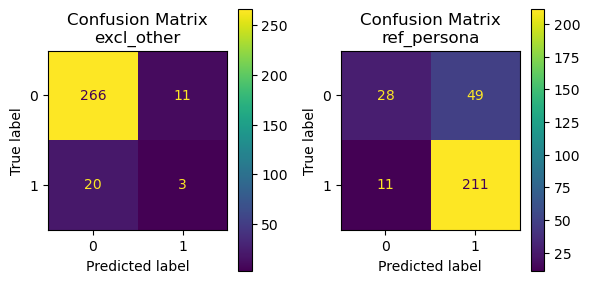

In [125]:
# analyze results
excl_crit_preds_df = analyze_predictions(
    train_docs_excl_crit_preds,
    gold_standard_annotations,
    gold_standard_comments,
    display_predictions=False,
    display_confusion_matrices=True
)

The accuracy values are similar to before. The confusion matrices show that the dataset is imbalanced for both both attributes. There are cases where the model falsely predicts the majority class, but overall the performance seems acceptable.

### Sentiment

From here on, to shorten the content of this notebook, the prompt engineering process is not documented and only the final best-performing prompt is shown.

In [10]:
# tagging sentiment attributes

sentiment_prompt = ChatPromptTemplate.from_template(
    """The following document is a YouTube comment that was posted under a YouTube video of a family VLOG. \
Determine the overall sentiment of the comment. If the sentiment is positive use 1, if it is negative -1 and 0 if it is neutral. \

Some comments might have an ambigous sentiment, for example if they are partly positive and partly negative. \
If the sentiment is ambigous output a 1 for ambiguity. If it is not ambiguous output a 0 for ambiguity. \

{input}
"""
)

schema = {
    "properties": {
        "sentiment_overall": {
            "type": "string",
            "enum": ["-1", "0", "1"],
            "description": "Sentiment of the comment"
        },
        "ambiguity": {
            "type": "string",
            "enum": ["0", "1"],
            "description": "Is the sentiment ambiguous?"
        }
    },
    "required": ["sentiment_overall", "ambiguity"]
}

sentiment_document_transformer = create_metadata_tagger(metadata_schema=schema, llm=llm, prompt=sentiment_prompt)

train_docs_sentiment_preds = sentiment_document_transformer.transform_documents(train_docs)

Accuracy sentiment_overall: 0.6613545816733067
Accuracy ambiguity: 0.7768924302788844


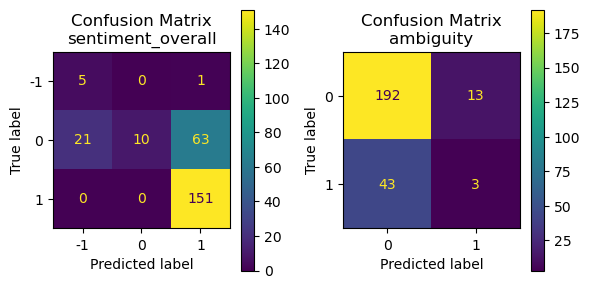

In [16]:
analyze_predictions(
    train_docs_sentiment_preds,
    gold_standard_annotations,
    gold_standard_comments,
    display_confusion_matrices=True,
    display_predictions=False
)

The attributes are, similar to before, unbalanced. Here, it can be seen that the LLM with the chosen prompt has difficulties correctly classifying the minority classes. For example, the comments are mostly labeled to have a positive sentiment, while they are often neutral.

### Cognitive

Again, only the best-performing prompt of the cogitive category is shown below.

In [75]:
# tagging cognitive attributes

cognitive_prompt = ChatPromptTemplate.from_template(
    """The following document is a YouTube comment that was posted under a YouTube video of a family VLOG. \
Determine the following attributes which are related to the cognitive response of the commenter to the video. \

The attribute comprehension indicates if the commenter somehow expresses being able to understands the situation \
or motivation of a person from the video. If you think this applies to the comment output 1 otherwise 0. \

The attribute memory_relate indicates if the commenter relates something that a person from the video does or says \
to a memory of a situation or to other persons in his or her life. If you think this applies to the comment output 1 otherwise 0. \

The attribute self_relate indicates if the commenter relates a person to himself or herself. \
This could for example be the case if the commenter makes a comparison between himself / herself and a person from the video. \
If you think this applies to the comment output 1 otherwise 0. \

The attribute evaluation indicates if the commenter evaluates or judges a person from the video or his / her behaviour. \
For example the commenter might reference a positive aspect of the person, give a compliment or critisize something about the person. \
It does not matter if the judgement is good or bad. If you think this applies to the comment output 1 otherwise 0. \

The attribute future indicates if the comment references future situations or motivations of a person from the video. \
If you think this applies to the comment output 1 otherwise 0. \

{input}
"""
)

schema = {
    "properties": {
        "comprehension": {
            "type": "string",
            "enum": ["0", "1"],
            "description": "Does the commenter reference being (not) able to understand the situation or motivation of the persona?"
        },
        "memory_relate": {
            "type": "string",
            "enum": ["0", "1"],
            "description": "Does the commenter relate something that a person from the video does or says to a memory of a situation or other persons in his life."
        },
        "self_relate": {
            "type": "string",
            "enum": ["0", "1"],
            "description": "Does the commenter make a comparison between themselves and another person?"
        },
        "evaluation": {
            "type": "string",
            "enum": ["0", "1"],
            "description": "Does the commenter judge another person or another person’s actions (in a good or a bad way)?"
        },
        "future": {
            "type": "string",
            "enum": ["0", "1"],
            "description": "Does the commenter reference future situations or motivations of the persona?"
        }
    },
    "required": ["comprehension", "memory_relate", "self_relate", "evaluation", "future"]
}

cognitive_document_transformer = create_metadata_tagger(metadata_schema=schema, llm=llm, prompt=cognitive_prompt)

train_docs_cognitive_preds = cognitive_document_transformer.transform_documents(train_docs)

Accuracy comprehension: 0.749003984063745
Accuracy memory_relate: 0.9083665338645418
Accuracy self_relate: 0.701195219123506
Accuracy evaluation: 0.6772908366533864
Accuracy future: 0.668


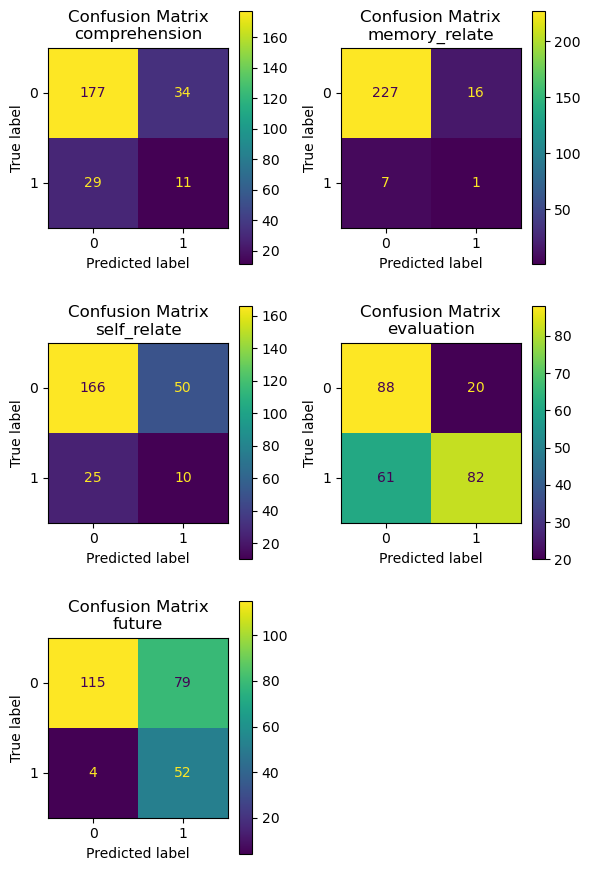

In [127]:
analyze_predictions(
    train_docs_cognitive_preds,
    gold_standard_annotations,
    gold_standard_comments,
    display_predictions=False,
    display_confusion_matrices=True
)

While the predictions of some of the attributes in the cognitive category achieved good accuracy values, these attributes are again the ones that are the most imbalanced. Predictions of other attributes, like the attributes future and evaluation are less reliable.

### Affective

The best performing prompt for the affective category is shown below.

In [13]:
# tagging affective attributes

affective_prompt = ChatPromptTemplate.from_template(
    """The following document is a YouTube comment that was posted under a YouTube video of a family VLOG.
Determine the following attributes which are related to the cognitive response of the commenter to the video. \

The attribute sympathy_antipathy indicates if the commenter expresses positive or negative feelings \
towards a person from the video on an emotional level. If you think this applies to the comment output 1 otherwise 0. \

The attribute empathy_counterempathy indicates if the commenter expresses feeling the same emotions as \
a person from the video. If you think this applies to the comment output 1 otherwise 0. \

The attribute emotion_release indicates if the commenter states that the mood or emotion of a person from the video \
had a significant impact on the commenter to the extent that they were deeply absorbed and almost felt the same \
emotion. If you think this applies to the comment output 1 otherwise 0. \

{input}
"""
)

schema = {
    "properties": {
        "sympathy_antipathy": {
            "type": "string",
            "enum": ["0", "1"],
            "description": "Does the commenter express positive or negative feelings towards the person?"
        },
        "empathy_counterempathy": {
            "type": "string",
            "enum": ["0", "1"],
            "description": "Does the commenter express experiencing the same emotions as the person?"
        },
        "emotion_release": {
            "type": "string",
            "enum": ["0", "1"],
            "description": "Did the mood or emotions of the persona have a significant impact on the commenter to the extent that they were deeply absorbed and almost felt the same emotions as the persona?"
        },
    },
    "required": ["sympathy_antipathy", "empathy_counterempathy", "emotion_release"]
}

affective_document_transformer = create_metadata_tagger(metadata_schema=schema, llm=llm, prompt=affective_prompt)

train_docs_affective_preds = affective_document_transformer.transform_documents(train_docs)

Accuracy sympathy_antipathy: 0.545816733067729
Accuracy empathy_counterempathy: 0.812
Accuracy emotion_release: 0.896414342629482


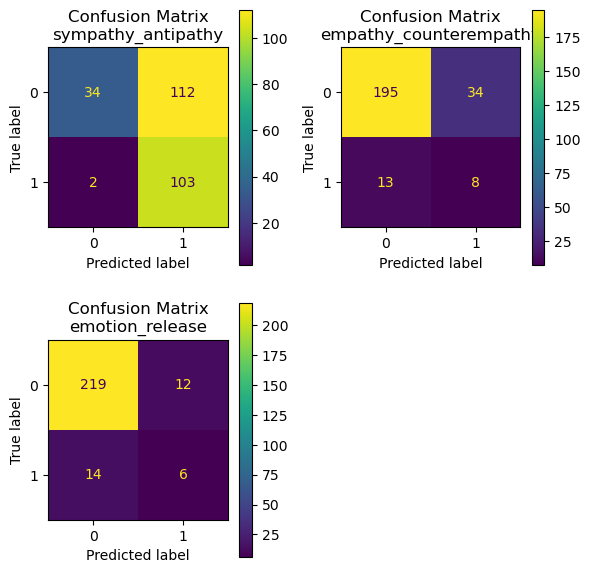

In [14]:
analyze_predictions(
    train_docs_affective_preds,
    gold_standard_annotations,
    gold_standard_comments,
    display_predictions=False,
    display_confusion_matrices=True
)

The predictions of the affective category exhibit the same pattern as the previous categories, where imbalanced attributes achieve higher accuracies. Here, the predictions of the emotion_release and empathy_counterempathy attribute are acceptable, while the predictions of the sympathy_antipathy attribute are not reliable at all. The model mostly predicts a presence of sympathy or antipathy in the comments while only roughly half of the comments were labeled as such.

## Conclusion

This notebook showed that while zero-shot prompting with large language models seems to be a plausible approach for automatically coding YouTube comments, there are attributes that seem to be very difficult to predict correctly. Further prompt engineering or separating the prompts even further (e.g. one prompt per attribute) might be a direction for further experiments.

There are two downsides of the presented approach, which are directly connected to the usage of the proprietary GPT-3 model. First, due to the model being proprietary and usable through the OpenAI API, the experiments are only reproducible as long as OpenAI supports the model. Furthermore, changes to the model are solely under the control of OpenAI, which further reduces the reproducibility of this experiment. The second downside is the cost involved in using the OpenAI API. The API is paid for by the amount of tokens and annotating one comment involves multiple prompts. Roughly 0.25\\$ were charged for running all the prompts on 300 comments. Annotating all comments in the unlabeled dataset would thus cost roughly 233\\$. For the two mentioned disadvantages we did further experiments with SetFit. The experiments are documented in the next notebook.

## References

[1] Brown et al. (2020). Language Models are Few-Shot Learners. Advances in Neural Information Processing Systems.  
[2] Chase (2022). Langchain. https://github.com/langchain-ai/langchain.  
[3] Ekin (2023). Prompt Engineering For ChatGPT: A Quick Guide To Techniques, Tips, And Best Practices. TechRxiv.  
[4] Lo (2023). The Art and Science of Prompt Engineering: A New Literacy in the Information Age. Internet Reference Services Quarterly.  